# Ensemble Techniques Project

## Context:

Leveraging customer information is paramount for most businesses. In the case of a bank,
attributes of customers like the ones mentioned below can be crucial in strategizing a
marketing campaign when launching a new product.

## Data description:

The data is related with direct marketing campaigns of a Portuguese banking institution.
The marketing campaigns were based on phone calls. Often, more than one contact to
the same client was required, in order to access if the product (bank term deposit) would
be ('yes') or not ('no') subscribed. 

## Attribute information:

**1. age** (numeric)  
**2. job** : type of job (categorical: 'admin.','bluecollar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')  
**3. marital** : marital status (categorical: 'divorced','married','single','unknown';
note: 'divorced' means divorced or widowed)  
**4. education** (categorical):
'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','univers
ity.degree','unknown')  
**5. default**: has credit in default? (categorical: 'no','yes','unknown')  
**6. balance**: average yearly balance, in euros (numeric)  
**7. housing**: has housing loan? (categorical: 'no','yes','unknown')  
**8. loan**: has personal loan? (categorical: 'no','yes','unknown')  
**9. contact**: contact communication type (categorical: 'cellular','telephone')  
**10.day**: last contact day of the month (numeric 1 -31)  
**11.month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
**12.duration**: last contact duration, in seconds (numeric). Important note: this
attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet,
the duration is not known before a call is performed. Also, after the end of the
call y is obviously known. Thus, this input should only be included for benchmark
purposes and should be discarded if the intention is to have a realistic predictive
model.  
**13.campaign**: number of contacts performed during this campaign and for this
client (numeric, includes last contact)  
**14.pdays**: number of days that passed by after the client was last contacted from a
previous campaign (numeric; 999 means client was not previously contacted)  
**15.previous**: number of contacts performed before this campaign and for this client
(numeric)  
**16.poutcome**: outcome of the previous marketing campaign (categorical:
'failure','nonexistent','success')  
**17.target**: has the client subscribed a term deposit? (binary: "yes","no")  

## Objective:

The classification goal is to predict if the client will subscribe (yes/no) a term deposit
(variable y).

In [24]:
# Import necessary libraries

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import warnings
import joblib

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('mode.chained_assignment', None)

In [2]:
# Read csv file as dataframe

bank_depo_df = pd.read_csv('bank-full.csv')
bank_depo_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Check the shape, null values and data type of each attribute
bank_depo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### There 45211 rows with 17 columns having no null values...
#### However, there are 10 string type columns which will need to be converted to numeric type  

In [4]:
# Check the data distribution within the columns
bank_depo_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


#### The minimum balance is -ve, which might mean that the customer owes money to the bank  
#### Let's check for outliers in each continuous feature and their count  

In [5]:
# Define function to calculate and print out the outlier count

def get_outlier_summary(data, cols, return_index=False):
    """
    Identifies the outliers in the data
    and returns the column-wise outlier indices
    
    Extended description of function.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe in which to find the outliers
    
    cols : list like iterable
        Columns across which to find the outliers
    
    return_index : Boolean, default=False
        If True, returns the combined set of indices having outliers in at least one column
    
    Returns
    ----------
    set or int
        Based on return_index, returns either 
        combined set of indices having outlier in at least one column or 
        outliers count
    """
    
    global_indices = set()
    q1 = data[cols].quantile(0.25)
    q3 = data[cols].quantile(0.75)
    iqr = q3 - q1
    min_val = q1 - 1.5*iqr
    max_val = q3 + 1.5*iqr
    
    for col in cols:
        outliers = data[(data[col] > max_val[col]) | (data[col] < min_val[col])][col]
        outlier_count = outliers.count()
        local_indices = outliers.index
        global_indices.update(local_indices)
        print(f"Outliers in {col} are {outlier_count}")
            
    return global_indices if return_index else len(global_indices)

# Get the outlier in continuous features
outliers = get_outlier_summary(bank_depo_df, ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])
print(f"Total outliers: {outliers}")

Outliers in age are 487
Outliers in balance are 4729
Outliers in day are 0
Outliers in duration are 3235
Outliers in campaign are 3064
Outliers in pdays are 8257
Outliers in previous are 8257
Total outliers: 17018


#### To decide if we should remove the outliers, we need to have a look at the distribution for these variables. 

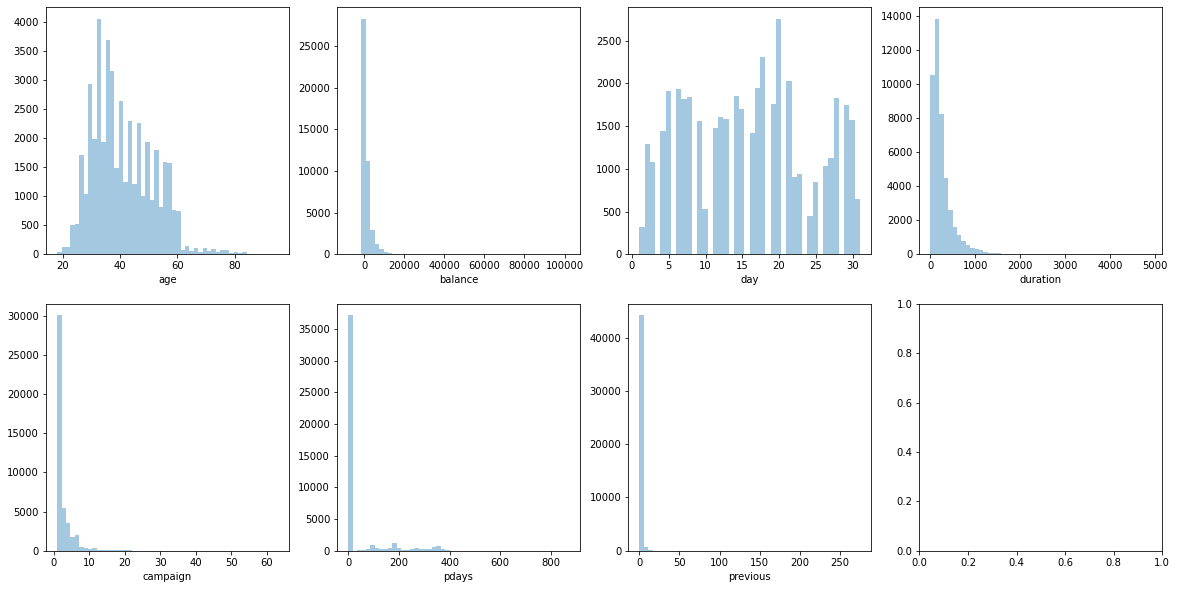

In [6]:
# Check distributions for continuous variables
continuous_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
f, axes = plt.subplots(2, 4, figsize=(20,10))

for i, var in enumerate(continuous_vars):
    sns.distplot(bank_depo_df[var], ax=axes.flatten()[i], kde=False)

**age** is slightly left skewed and **day** is evenly distributed.  
**duration**, **balance** and **campaign** are heavily left skewed.  
**pdays** and **previous** have most of the values as 0 or -1 which means the customer was not contacted before this campaign.  
#### Let's look at the target variable distribution  

In [7]:
# Target variable distribution

bank_depo_df['Target'].value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: Target, dtype: float64

#### The dataset is heavily imbalanced (Only has 11.6% customers who subscribed to term deposit)
#### Coming back to outliers, we see that due to the nature of distribution of these variables, mostly the larger values seem like outliers.
#### We will focus on few variables which have very heavy skew such as balance, pdays, previous and campaign to see their distribution of Target variable to either side of the threshold to make sure we can remove such values  
Note: We leave out duration because we will drop it anyway before building the model (see attributes description)

In [8]:
## We choose the threshold based on the plots above 
#  For balance, we can test with threshold=20000
#  For pdays, we can test with threshold=400
#  For previous we can test with threshold=25
#  For campaign we can test with threshold=25

thresholds = {
    'balance': 20000,
    'pdays': 400,
    'previous': 25,
    'campaign': 25
}

for col in thresholds:
    # We won't tolerate the distribution to go over 20% (in favour of class 1) for the right side of threshold
    ratio = bank_depo_df[bank_depo_df[col]>thresholds[col]]['Target'].value_counts(normalize=True)['yes']
    if ratio > 0.2:
        print(f"Threshold of {thresholds[col]} for {col} is NOT OK")
    else:
        print(f"Threshold of {thresholds[col]} for {col} is OK")

Threshold of 20000 for balance is OK
Threshold of 400 for pdays is NOT OK
Threshold of 25 for previous is OK
Threshold of 25 for campaign is OK


#### So we remove outliers for balance, previous and campaign

In [9]:
bank_depo_df = bank_depo_df[bank_depo_df['balance'] <= 20000]
bank_depo_df = bank_depo_df[bank_depo_df['previous'] <= 25]
bank_depo_df = bank_depo_df[bank_depo_df['campaign'] <= 25]

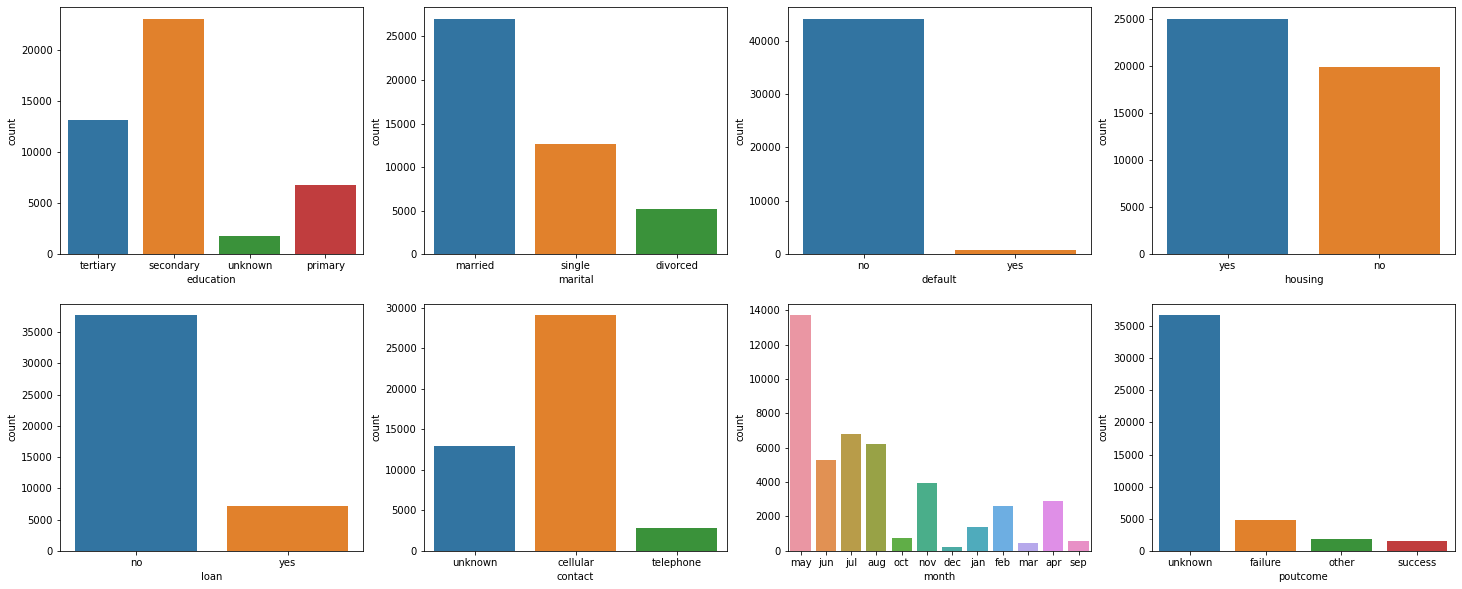

In [10]:
# Check distributions for discrete variables
discrete_vars = ['education', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
f, axes = plt.subplots(2, 4, figsize=(25,10))

for i, var in enumerate(discrete_vars):
    sns.countplot(x=bank_depo_df[var], orient='v', ax=axes.flatten()[i])

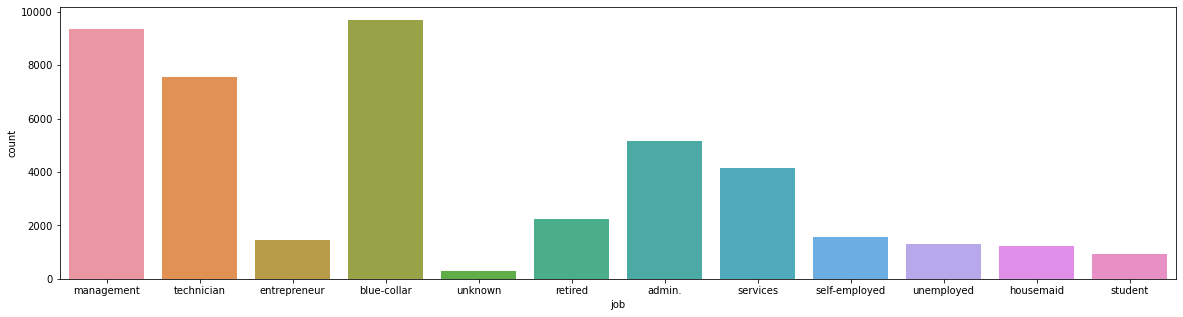

In [11]:
# Plot distribution for job seperately due to long labels
f, axes = plt.subplots(1, 1, figsize=(20,5))
sns.countplot(x=bank_depo_df['job'], orient='v', ax=axes)

**Education**: Almost half of the customers have secondary education.  
**Marital**: Almost 60% of the customers are Married.  
**default**: Very few customers have default in their credit.  
**Housing**: Majority of the customers have taken housing loan.  
**loan**: Only 16-18% customers have taken a personal loan.  
**contact**: Around two-thirds of customers have been contacted by cellular  
**month**: Most of the customers have been contacted from May-Aug with most being in May  
**poutcome**: For customers who have been contacted, around 80% have no outcome of previous contacts (maybe because they have not been contacted before)  
**job**: Majority of customers are either in blue-collar, technician or management roles.  

## Some Bivariate analysis:

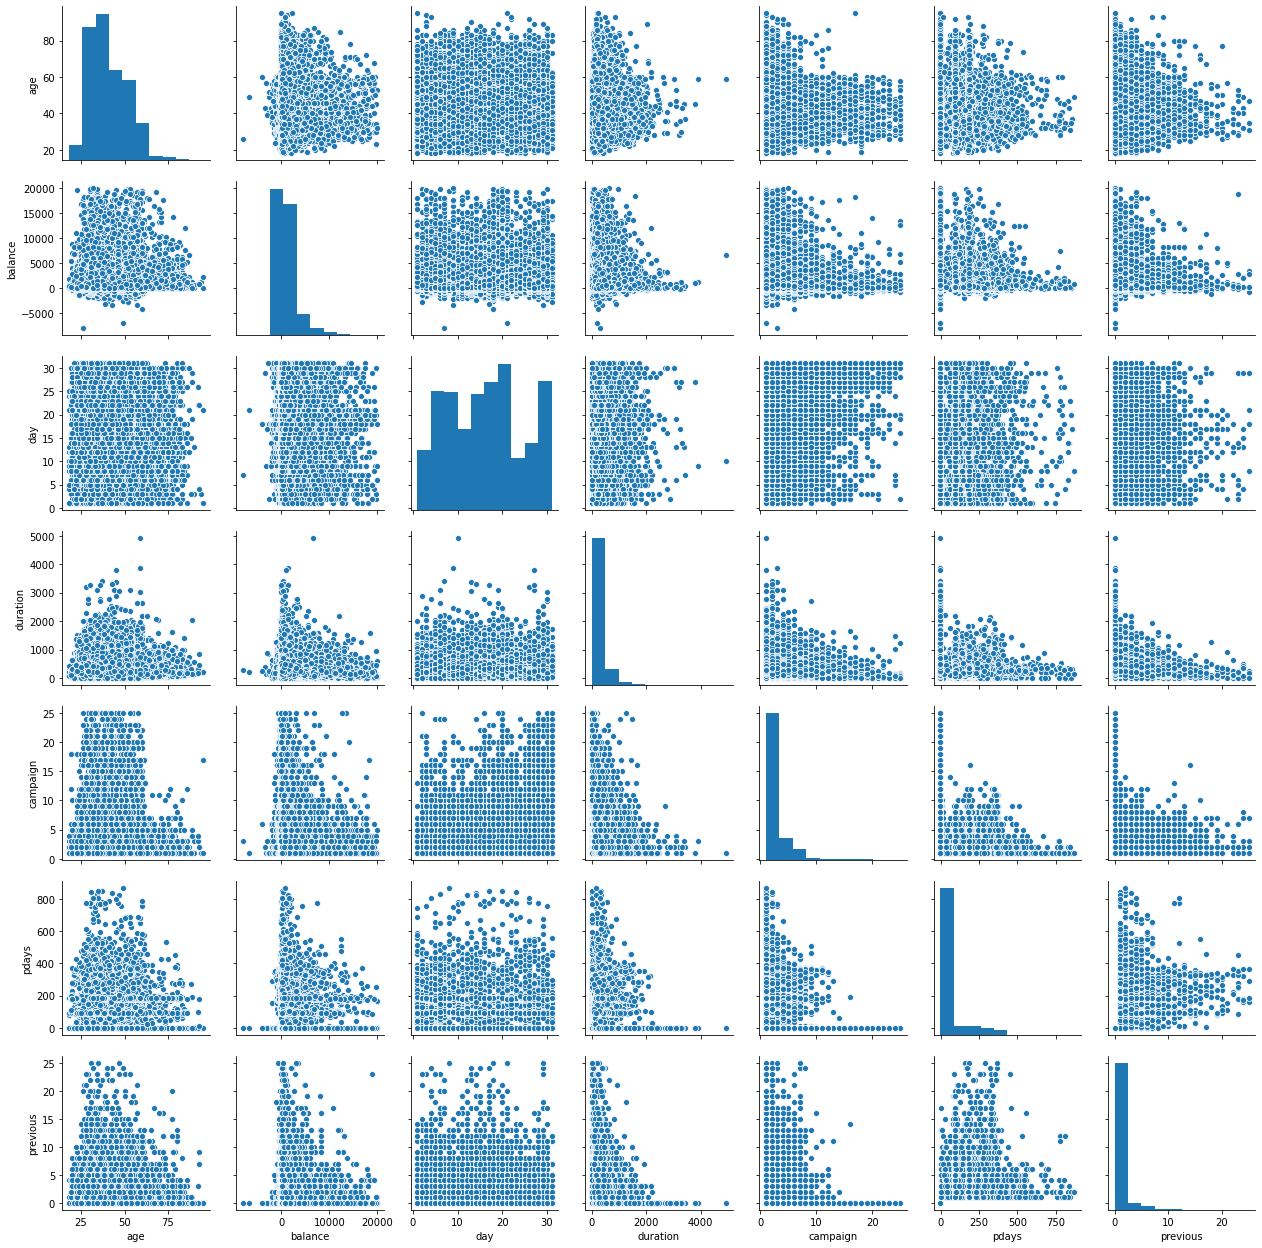

In [12]:
# We use seaborn pairplot to do the bivariate analysis for continuous features and target 

sns.pairplot(bank_depo_df, vars=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

#### 2-D analysis of these variables reveals a few things such as the presence of outlier in 'balance' feature (extremely -ve balances) We will remove such values to ensure they don't affect our models.

In [13]:
# After eye-balling from above plot for balance, we chose -1500 as cutoff threshold

bank_depo_df = bank_depo_df[bank_depo_df['balance'] >= -1500]

## Some Multivariate analysis:

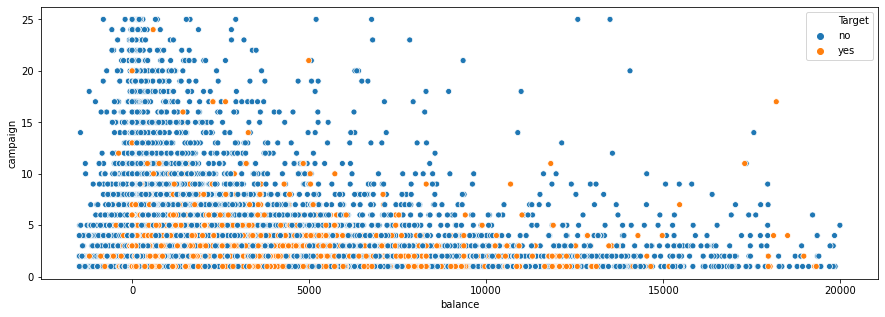

In [14]:
# Balance vs campaign split by Target
f, axes = plt.subplots(1, 1, figsize=(15,5))

sns.scatterplot(x='balance', y='campaign', data=bank_depo_df, hue='Target', ax=axes)

#### This seem to suggest that it is not necessarily true that higher campaign contacts are required for conversion of customers 

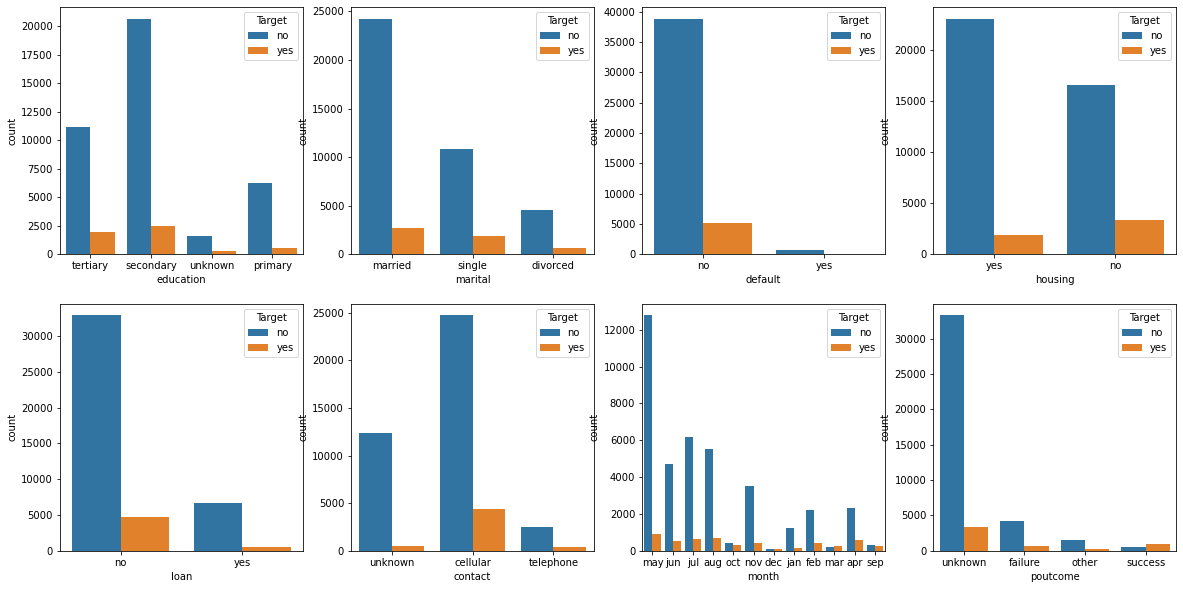

In [15]:
# Categorical vars vs Target
categ_vars = ['education', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
f, axes = plt.subplots(2, 4, figsize=(20,10))

for i, var in enumerate(categ_vars):
    sns.countplot(x=bank_depo_df[var], hue=bank_depo_df['Target'], orient='v', ax=axes.flatten()[i])

There are **higher** percent of term depositors in customers who have **completed tertiary education**  
People already **with housing loan** have opted **less** for term deposits wrt their counterparts

### Convert categorical columns to numerical columns

We have two kinds of categorical columns here.  

1. Either binary or ordinal. These are:  
**education**: Ordinal  
**default**: Binary  
**housing**: Binary  
**loan**: Binary  
**Target**: Binary  
  
2. Multinomial without order. These are:  
**marital**: Multinomial  
**contact**: Multinomial  
**month**: Multinomial  
**poutcome**: Multinomial  
**job**: Multinomial  

For **type 1**, we will label encode them  
For **type 2**, we will generate dummy columns

In [16]:
# Give labels to type 1 columns

def encode_education(val):
    if val=='unknown':
        return -1
    elif val=='primary':
        return 1
    elif val=='secondary':
        return 2
    else:
        return 3

def encode_rest(val):
    return 1 if val=='yes' else 0

# Apply encoding to education
bank_depo_df['education'] = bank_depo_df['education'].apply(encode_education)

# Apply encoding to default, housing, loan and Target
bank_depo_df['default'] = bank_depo_df['default'].apply(encode_rest)
bank_depo_df['housing'] = bank_depo_df['housing'].apply(encode_rest)
bank_depo_df['loan'] = bank_depo_df['loan'].apply(encode_rest)
bank_depo_df['Target'] = bank_depo_df['Target'].apply(encode_rest)

### Before generating dummy cols, let's have a look at the correlation plot:

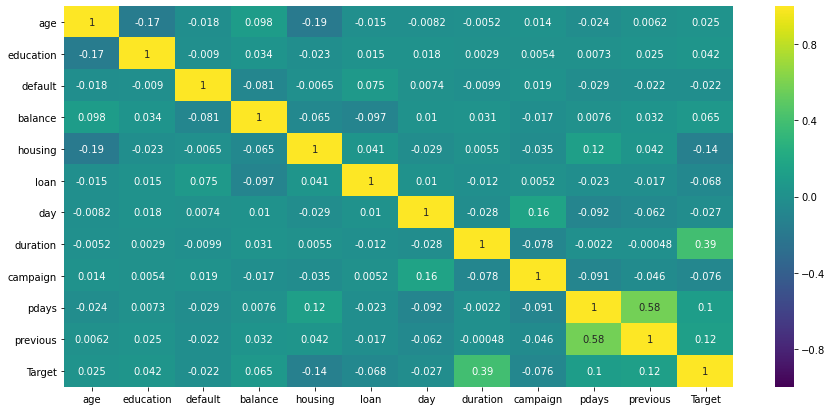

In [17]:
# Correlation among variables
plt.figure(figsize=[15,7])

sns.heatmap(bank_depo_df.corr(), cmap='viridis', vmin=-1, vmax=1, annot=True)

There is good correlation between **pdays** and **previous**  
There is relatively good correlation between **duration** and **Target**, but **duration** will be dropped from dataset soon (See Attribute information)  

In [18]:
# Generate dummy columns for multinomial features and drop duration
bank_depo_df = pd.get_dummies(bank_depo_df, drop_first=True)
bank_depo_df.drop('duration', axis=1, inplace=True)

## Model Building starts...

In [19]:
from sklearn.model_selection import train_test_split

X = bank_depo_df.drop('Target', axis=1)
y = bank_depo_df['Target']

# Note: Set stratify to make sure class imbalances are preserved after split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

# Verify distribution of target variable in test set
y_test.value_counts(normalize=True)

0    0.882874
1    0.117126
Name: Target, dtype: float64

#### Since many of continuous features have a larger scale, we need to scale them out to bring them closer to categorical features.
#### For this, we will use MinMaxScaler (and not StandardScaler) which will preserve the distribution of the data in features
#### Note: We do the scaling seperately on train and test set so as to mimic the real world scenario where we obviously can't scale the incoming data with train data that has been used to build the model

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.fit_transform(X_test, y_test)

### Build and test the following models:  
     1. Naive Bayes  
     2. Logistic  
     3. Decision Tree  
     4. Bagging Classifier 
     5. Adaboost Classifier  
     6. Gradient Boosting Classifier  
     7. XGBoost Classifier  
     8. Random Forest Classifier  
#### First we will set the base line for accuracy using Naive Bayes and then use Grid search CV to find the best hyper-parameters for other models

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_proba = gnb.predict_proba(X_test)
y_pred = gnb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     11872
           1       0.37      0.42      0.40      1575

    accuracy                           0.85     13447
   macro avg       0.65      0.66      0.66     13447
weighted avg       0.86      0.85      0.85     13447



### Now we find the best hyper parameters for each of the above models using Grid search CV
**Note:** We will be leaving out Naive-Bayes as there isn't much tuning that can be done

In [22]:
# We create a generic grid search function which can be used for multiple ML models/algorithms

import copy
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def get_best_model(X, y, estimator_specs):
    """
    Finds the best model among the estimators among all possible ones
    as defined in param_grid and returns the best estimator.

    Extended description of function.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Samples vector, where n_samples is the number of samples and
        n_features is the number of features.
    
    y : array-like of shape (n_samples,)
        Target vector relative to X.
    
    estimator_specs : list of dictionaries
        List of dictionaries where each dictionary specifies the details of a single estimator object.
        The dictionary has following keys and values:
        
            estimator  : estimator object
                An estimator object (classifier instance)
                
            params : dict or list of dictionaries
                Dictionary with parameters names (string) as keys and lists of parameter settings to try as values,
                or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored.
                This enables searching over any sequence of parameter settings.
                
            scorer : scoring function or None
                A custom scoring function. This goes as a value to 'scoring' argument in GridSearchCV.
                If None, then estimator's score function is used.
    
    Returns
    -------
    List of estimator objects(as dictionaries)
        List of dictionaries of best estimator object (which has best score) along with their scores and results.

    """
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    results = list()
    for estimator in estimator_specs:
        best_estimator = dict()
        gs_object = GridSearchCV(estimator['estimator'],
                                param_grid=estimator['params'],
                                scoring=estimator['scorer'],
                                cv=kfold,
                                verbose=2)
        gs_object.fit(X, y)
        best_estimator['estimator'] = gs_object.best_estimator_
        best_estimator['score'] = gs_object.best_score_
        best_estimator['results'] = pd.DataFrame(gs_object.cv_results_).drop('params', axis=1)
        results.append(copy.deepcopy(best_estimator))
    
    return results

In [23]:
# We will be providing grid search with complete dataset as it internally would use stratified k-fold cross validation
# Hence, we need to scale the whole data prior to that
X = scaler.fit_transform(X, y)

# We will use the roc_auc_score as our custom scorer
from sklearn.metrics import make_scorer, roc_auc_score
custom_scorer = make_scorer(roc_auc_score, needs_proba=True)

### First we will try the base models

In [25]:
# We define the parameter grids for each of the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
logsitic_params = [
    {'C': [0.01, 0.1, 0.5, 1.0, 10, 100, 1000], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 0.5, 1.0, 10, 100, 1000], 'solver': ['lbfgs'], 'penalty': ['l2']}
]

# Decision Trees
dtree_params = {'max_depth': [3, 4, 5, 6, 7]}

# Define estimator specs for each model to be passed into get_best_model()
estimator_specs = [
    {
        # Logistic Regression
        'estimator': LogisticRegression(max_iter=1000, random_state=42),
        'params'   : logsitic_params,
        'scorer'   : custom_scorer
    },
    {
        # D tree
        'estimator': DecisionTreeClassifier(random_state=42),
        'params'   : dtree_params,
        'scorer'   : custom_scorer
    },
]

base_results = get_best_model(X, y, estimator_specs)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV] C=0.01, penalty=l1, solver=liblinear ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] .

[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.9s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.8s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.6s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .

[CV] .............. C=100, penalty=l2, solver=liblinear, total=   0.2s
[CV] C=100, penalty=l2, solver=liblinear .............................
[CV] .............. C=100, penalty=l2, solver=liblinear, total=   0.2s
[CV] C=1000, penalty=l1, solver=liblinear ............................
[CV] ............. C=1000, penalty=l1, solver=liblinear, total=   1.0s
[CV] C=1000, penalty=l1, solver=liblinear ............................
[CV] ............. C=1000, penalty=l1, solver=liblinear, total=   0.9s
[CV] C=1000, penalty=l1, solver=liblinear ............................
[CV] ............. C=1000, penalty=l1, solver=liblinear, total=   0.9s
[CV] C=1000, penalty=l1, solver=liblinear ............................
[CV] ............. C=1000, penalty=l1, solver=liblinear, total=   0.8s
[CV] C=1000, penalty=l1, solver=liblinear ............................
[CV] ............. C=1000, penalty=l1, solver=liblinear, total=   1.0s
[CV] C=1000, penalty=l1, solver=liblinear ............................
[CV] .

[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.4s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.4s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.4s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.4s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   0.4s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   0.3s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   0.3s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  1.4min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.3s finished


In [26]:
for algo in base_results:
    print(f"Best Base Estimator: {algo['estimator']}")
    print(f"Best Base Score: {algo['score']}\n")

Best Base Estimator: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best Base Score: 0.7663762501474572

Best Base Estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Best Base Score: 0.7126303350115986



### We get decent performance using Logistic regression but not so with Decision Trees. Let's see if we can surpass this score with ensemble methods

In [26]:
# We define the parameter grids for each of the models
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# Bagging 
bagging_params = {'n_estimators': [10, 50, 100, 300]}

# Adaboost
adaboost_params = {
                    'n_estimators': [10, 50, 100, 300],
                    'learning_rate': [0.2, 0.5, 0.7, 1.0] 
                  }

# Gradient boost
gradboost_params = {
                     'n_estimators': [10, 50, 100, 150, 300],
                     'learning_rate': [0.1, 0.3, 0.5, 1.0],
                     'max_depth': [3, 5, 7],
                     'max_features': ['auto', None]
                   }

# Random Forest
rf_params = {
                'n_estimators': [50, 100, 150, 200, 300],
                'max_features': ['log2', 'auto'],
                'max_depth': [3, 5, 7]
}

# Define estimator specs for each model to be passed into get_best_model()
estimator_specs = [
    {
        # Bagging
        'estimator': BaggingClassifier(random_state=42),
        'params'   : bagging_params,
        'scorer'   : custom_scorer
    },
    {
        # Adaboost
        'estimator': AdaBoostClassifier(random_state=42),
        'params'   : adaboost_params,
        'scorer'   : custom_scorer
    },
    {
        # Gradient boost
        'estimator': GradientBoostingClassifier(random_state=42),
        'params'   : gradboost_params,
        'scorer'   : custom_scorer 
    },
    {
        # RF 
        'estimator': RandomForestClassifier(random_state=42),
        'params'   : rf_params,
        'scorer'   : custom_scorer 
    }
]

ensemble_results = get_best_model(X, y, estimator_specs)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=10, total=   3.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   3.1s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.1s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.1s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.1s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.0s
[CV] n_estimators=10 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 22.4min finished


Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] learning_rate=0.2, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.7s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] ............... learning_rate=0.2, n_estimators=10, total=   0.6s
[CV] learning_rate=0.2, n_estimators=10 ..............................
[CV] .

[CV] ............... learning_rate=0.5, n_estimators=50, total=   2.9s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .............. learning_rate=0.5, n_estimators=100, total=   5.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .............. learning_rate=0.5, n_estimators=100, total=   5.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .............. learning_rate=0.5, n_estimators=100, total=   5.9s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .............. learning_rate=0.5, n_estimators=100, total=   5.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .............. learning_rate=0.5, n_estimators=100, total=   5.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .............. learning_rate=0.5, n_estimators=100, total=   5.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .

[CV] .............. learning_rate=0.7, n_estimators=300, total=  17.5s
[CV] learning_rate=0.7, n_estimators=300 .............................
[CV] .............. learning_rate=0.7, n_estimators=300, total=  17.5s
[CV] learning_rate=0.7, n_estimators=300 .............................
[CV] .............. learning_rate=0.7, n_estimators=300, total=  17.6s
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] ............... learning_rate=1.0, n_estimators=10, total=   0.6s
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] ............... learning_rate=1.0, n_estimators=10, total=   0.6s
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] ............... learning_rate=1.0, n_estimators=10, total=   0.6s
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] ............... learning_rate=1.0, n_estimators=10, total=   0.6s
[CV] learning_rate=1.0, n_estimators=10 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 17.9min finished


Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth

[CV]  learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth

[CV]  learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth

[CV]  learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=5, max_features=None, n_estimators=10, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.1, max_depth

[CV]  learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=50, total=  11.0s
[CV] learning_rate=0.1, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.1, max_depth

[CV]  learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10 
[CV]  learning_rate=0.1, max_depth=7, max_features=None, n_estimators=10, total=   2.2s
[CV] learning_rate=0.1, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=7, max_features=None, n_estimators=50, total=  11.0s
[CV] learning_rate=0.1, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=7, max_features=None, n_estimators=50, total=  11.0s
[CV] learning_rate=0.1, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.1, max_depth

[CV]  learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=10 
[CV]  learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=10, total=   1.1s
[CV] learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50, total=   5.4s
[CV] learning_rate=0.3, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth

[CV]  learning_rate=0.3, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.3, max_depth=3, max_features=None, n_estimators=10 
[CV]  learning_rate=0.3, max_depth=3, max_features=None, n_estimators=10, total=   1.1s
[CV] learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.3, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth

[CV]  learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=10, total=   1.7s
[CV] learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50, total=   8.4s
[CV] learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50, total=   8.3s
[CV] learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50, total=   8.5s
[CV] learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50, total=   8.4s
[CV] learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50, total=   8.4s
[CV] learning_rate=0.3, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth

[CV]  learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50, total=   8.5s
[CV] learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50, total=   8.4s
[CV] learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50, total=   8.5s
[CV] learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50, total=   8.4s
[CV] learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50, total=   8.5s
[CV] learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50, total=   8.4s
[CV] learning_rate=0.3, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth

[CV]  learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50, total=  11.6s
[CV] learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50, total=  11.6s
[CV] learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50, total=  11.4s
[CV] learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50, total=  11.8s
[CV] learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50, total=  11.5s
[CV] learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50, total=  11.4s
[CV] learning_rate=0.3, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.3, max_depth

[CV]  learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50, total=  11.6s
[CV] learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50, total=  11.4s
[CV] learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50, total=  11.5s
[CV] learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50, total=  11.5s
[CV] learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50, total=  11.4s
[CV] learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50, total=  11.4s
[CV] learning_rate=0.3, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.3, max_depth

[CV]  learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50, total=   5.4s
[CV] learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth

[CV]  learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50, total=   5.4s
[CV] learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=3, max_features=None, n_estimators=50, total=   5.3s
[CV] learning_rate=0.5, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_dept

[CV]  learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50, total=   8.4s
[CV] learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50, total=   8.4s
[CV] learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50, total=   8.5s
[CV] learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50, total=   8.5s
[CV] learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=50, total=   8.5s
[CV] learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=100, total=  16.9s
[CV] learning_rate=0.5, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=0.5, max_de

[CV]  learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50, total=   8.4s
[CV] learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50, total=   8.4s
[CV] learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50, total=   8.5s
[CV] learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=5, max_features=None, n_estimators=50, total=   8.5s
[CV] learning_rate=0.5, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=5, max_features=None, n_estimators=100, total=  16.9s
[CV] learning_rate=0.5, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=5, max_features=None, n_estimators=100, total=  17.0s
[CV] learning_rate=0.5, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_

[CV]  learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=50, total=  11.5s
[CV] learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=50, total=  11.4s
[CV] learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=50, total=  11.7s
[CV] learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100, total=  22.9s
[CV] learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100, total=  22.9s
[CV] learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100, total=  22.9s
[CV] learning_rate=0.5, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=0.5, ma

[CV]  learning_rate=0.5, max_depth=7, max_features=None, n_estimators=50, total=  11.5s
[CV] learning_rate=0.5, max_depth=7, max_features=None, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=7, max_features=None, n_estimators=50, total=  11.7s
[CV] learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100, total=  22.7s
[CV] learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100, total=  23.1s
[CV] learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100, total=  23.2s
[CV] learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100, total=  23.0s
[CV] learning_rate=0.5, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=0.5, 

[CV]  learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=50, total=   5.3s
[CV] learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100, total=  10.8s
[CV] learning_rate=1.0, max_depth=3, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0

[CV]  learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100, total=  10.6s
[CV] learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100, total=  10.7s
[CV] learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100, total=  11.3s
[CV] learning_rate=1.0, max_depth=3, max_features=None, n_estimators=100 
[CV]  learning_rate=1.

[CV]  learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100, total=  17.2s
[CV] learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100, total=  17.2s
[CV] learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100, total=  17.3s
[CV] learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100, total=  17.1s
[CV] learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100, total=  17.1s
[CV] learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100, total=  17.2s
[CV] learning_rate=1.0, max_depth=5, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.

[CV]  learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100, total=  17.4s
[CV] learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100, total=  17.4s
[CV] learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100, total=  17.2s
[CV] learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100, total=  17.1s
[CV] learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100, total=  17.5s
[CV] learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100, total=  17.9s
[CV] learning_rate=1.0, max_depth=5, max_features=None, n_estimators=100 
[CV]  learning_rate=1.

[CV]  learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100, total=  23.7s
[CV] learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100, total=  23.6s
[CV] learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100, total=  23.3s
[CV] learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100, total=  22.8s
[CV] learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100, total=  23.1s
[CV] learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100, total=  22.8s
[CV] learning_rate=1.0, max_depth=7, max_features=auto, n_estimators=100 
[CV]  learning_rate=1.

[CV]  learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100, total=  23.2s
[CV] learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100, total=  23.3s
[CV] learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100, total=  23.1s
[CV] learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100, total=  22.9s
[CV] learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100, total=  22.9s
[CV] learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=7, max_features=None, n_estimators=100, total=  22.9s
[CV] learning_rate=1.0, max_depth=7, max_features=None, n_estimators=150 
[CV]  learning_rate=1.

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 411.9min finished


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] max_depth=3, max_features=log2, n_estimators=50 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.8s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .

[CV] .. max_depth=3, max_features=auto, n_estimators=50, total=   1.0s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   1.9s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   1.9s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   1.9s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   1.8s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   1.8s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   1.8s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] .

[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   2.1s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   2.1s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   2.1s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   3.2s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   3.2s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   3.2s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   3.2s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] .

[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   3.5s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   3.5s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   4.1s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   3.5s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   3.6s
[CV] max_depth=5, max_features=auto, n_estimators=200 ................
[CV] . max_depth=5, max_features=auto, n_estimators=200, total=   4.7s
[CV] max_depth=5, max_features=auto, n_estimators=200 ................
[CV] . max_depth=5, max_features=auto, n_estimators=200, total=   4.7s
[CV] max_depth=5, max_features=auto, n_estimators=200 ................
[CV] .

[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   5.1s
[CV] max_depth=7, max_features=log2, n_estimators=300 ................
[CV] .

[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.5s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.6s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.6s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.5s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.6s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.5s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   8.5s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 17.9min finished


In [27]:
for algo in ensemble_results:
    print(f"Best ensemble Estimator: {algo['estimator']}")
    print(f"Best ensemble Score: {algo['score']}\n")

Best ensemble Estimator: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=300,
                  n_jobs=None, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)
Best ensemble Score: 0.7723075205010913

Best ensemble Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=300, random_state=42)
Best ensemble Score: 0.7822313766577054

Best ensemble Estimator: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,

## Save the ML models

In [1]:
model_mapping {
    0: 'bagging_classifier.sav',
    1: 'adaboost_classifier.sav',
    2: 'gradient_boost_classifier.sav',
    3: 'rf_classifier.sav'
}

for i, model in enumerate(ensemble_results):
    joblib.dump(model['estimator'], model_mapping[i])

In [28]:
# Try XG Boost
from xgboost import XGBClassifier

# XGBoost
xgboost_params = {
                     'n_estimators': [150, 200, 250, 300, 500],
                     'max_depth': [3, 5, 7, 9],
                     'learning_rate': [0.05, 0.1, 0.3, 0.5]
}

xgb_specs = [
    {
        # xgb
        'estimator': XGBClassifier(random_state=42),
        'params'   : xgboost_params,
        'scorer'   : custom_scorer         
    }
]

xgb_results = get_best_model(X, y, xgb_specs)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   7.0s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   6.6s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   6.5s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   6.5s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   6.8s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   7.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   7.4s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   6.8s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  

[CV]  learning_rate=0.05, max_depth=5, n_estimators=150, total=   9.4s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=  12.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=  12.5s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=  12.5s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=  12.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=  13.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=  12.5s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  

[CV]  learning_rate=0.05, max_depth=7, n_estimators=200, total=  16.5s
[CV] learning_rate=0.05, max_depth=7, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=200, total=  16.7s
[CV] learning_rate=0.05, max_depth=7, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=200, total=  16.6s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=  20.6s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=  21.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=  21.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=  21.3s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  

[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=  25.9s
[CV] learning_rate=0.05, max_depth=9, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=  25.9s
[CV] learning_rate=0.05, max_depth=9, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=  26.0s
[CV] learning_rate=0.05, max_depth=9, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=  26.0s
[CV] learning_rate=0.05, max_depth=9, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=  26.1s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=300, total=  30.8s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=300, total=  31.1s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  

[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  12.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  12.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  13.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  13.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  12.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  12.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=  12.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=500 ................
[CV] .

[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  30.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  30.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  31.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  31.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  30.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  31.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=  31.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] .

[CV] . learning_rate=0.1, max_depth=7, n_estimators=500, total=  41.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=  15.6s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=  15.5s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=  15.4s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=  16.0s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=  15.6s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=  15.8s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=3, n_estimators=150, total=   6.4s
[CV] learning_rate=0.3, max_depth=3, n_estimators=150 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=150, total=   6.5s
[CV] learning_rate=0.3, max_depth=3, n_estimators=150 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=150, total=   6.6s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   8.6s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   9.9s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   8.6s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   8.6s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=5, n_estimators=200, total=  12.4s
[CV] learning_rate=0.3, max_depth=5, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=200, total=  12.5s
[CV] learning_rate=0.3, max_depth=5, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=200, total=  12.8s
[CV] learning_rate=0.3, max_depth=5, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=200, total=  12.5s
[CV] learning_rate=0.3, max_depth=5, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=200, total=  12.5s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=  15.6s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=  15.4s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  20.4s
[CV] learning_rate=0.3, max_depth=7, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  21.8s
[CV] learning_rate=0.3, max_depth=7, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  20.4s
[CV] learning_rate=0.3, max_depth=7, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  20.3s
[CV] learning_rate=0.3, max_depth=7, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  20.7s
[CV] learning_rate=0.3, max_depth=7, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  20.4s
[CV] learning_rate=0.3, max_depth=7, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=  20.4s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  31.5s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  30.3s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  30.7s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  30.5s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  31.0s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  34.1s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=  30.8s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] .

[CV] . learning_rate=0.5, max_depth=3, n_estimators=300, total=  12.7s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=  21.2s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=  22.3s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=  21.9s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=  21.4s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=  22.4s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=  21.4s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] .

[CV] . learning_rate=0.5, max_depth=5, n_estimators=500, total=  31.0s
[CV] learning_rate=0.5, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=5, n_estimators=500, total=  30.7s
[CV] learning_rate=0.5, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=5, n_estimators=500, total=  30.6s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=  36.5s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=  37.8s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total= 1.1min
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=  27.6s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] .

[CV] . learning_rate=0.5, max_depth=9, n_estimators=150, total=  16.3s
[CV] learning_rate=0.5, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=150, total=  15.5s
[CV] learning_rate=0.5, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=150, total=  15.7s
[CV] learning_rate=0.5, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=150, total=  15.5s
[CV] learning_rate=0.5, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=150, total=  15.4s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=  20.9s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=  21.0s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] .

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 278.1min finished


In [29]:
print(f"Best xgb Estimator: {xgb_results[0]['estimator']}")
print(f"Best xgb Score: {xgb_results[0]['score']}\n")

Best xgb Estimator: XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Best xgb Score: 0.8017233136497174



In [31]:
# Save the Model
joblib.dump(xgb_results[0]['estimator'], 'xgboost.sav')

['xgboost.sav']

#### We have the best estimator for each of the algorithms and see that these have very close scores with XG Boost performing the best.
**Note:** We have defined our custom scorer which is roc_auc_score metric. Accuracy can be misleading when there are class imbalances. Also, we have used class probablities instead of class labels while scoring because this will later help us to find the optimum threshold to maximize f1-score

### Let's evaluate the top model for each algorithm which will help us decide the best model

In [44]:
# We define a function which prints out the classification report for a model and the roc_auc_curve
from sklearn.metrics import plot_roc_curve

def print_metrics(model, X_train, y_train, X_test, y_test, model_name=None, ax=None):
    """
    Fits the best estimator model on train set and predicts classes, then
    Prints out the classification report, roc_curve for the given model
    """
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Classification report for Model: {model_name}")
    print(classification_report(y_test, predictions)+"\n\n")
    plot_roc_curve(model, X_test, y_test, name=model_name, ax=ax)

#### We will consolidate all the models from previous runs

In [31]:
# Append logistic and decision tree models

trained_models = list()
base_models_list = ['Logistic Regression', 'Decision Tree']
for i, model in enumerate(base_results):
    trained_models.append({'algo': base_models_list[i],
                           'estimator': model['estimator']})

# Load the saved ensemble models for evaluation
ensemble_model_list = ['bagging_classifier', 'adaboost_classifier', 'gradient_boost_classifier', 'rf_classifier', 'xgboost']
for model in ensemble_model_list:
    trained_models.append({'algo': model,
                           'estimator': joblib.load(f'{model}.sav')})

Classification report for Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11872
           1       0.65      0.17      0.27      1575

    accuracy                           0.89     13447
   macro avg       0.77      0.58      0.60     13447
weighted avg       0.87      0.89      0.86     13447



Classification report for Model: Decision Tree
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11872
           1       0.59      0.21      0.31      1575

    accuracy                           0.89     13447
   macro avg       0.75      0.60      0.63     13447
weighted avg       0.87      0.89      0.87     13447



Classification report for Model: bagging_classifier
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     11872
           1       0.58      0.26      0.36      1575

    accuracy              

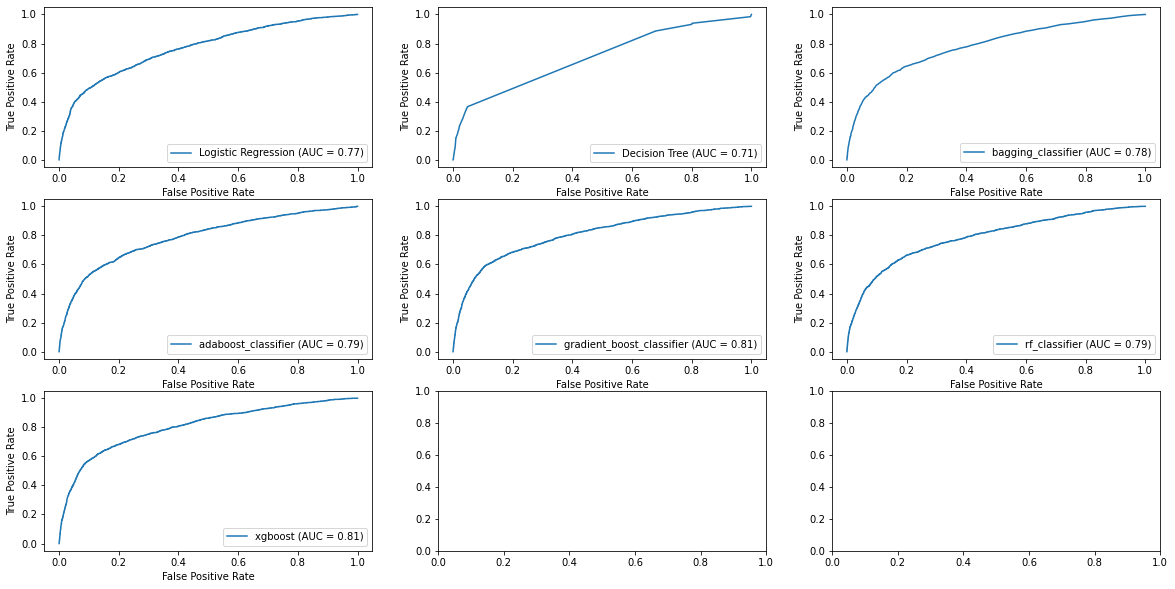

In [47]:
# Print metrics for all models

f, axes = plt.subplots(3, 3, figsize=(20,10))
for i, model in enumerate(trained_models):
    print_metrics(model['estimator'], X_train, y_train, X_test, y_test, model_name=model['algo'], ax=axes.flatten()[i])

### Despite all of them having same accuracies, we see that XG boost has slightly better AUC (From Grid search CV results)
### So we will proceed with XG boost model and adjust threshold to see if we can improve f1_score for Class 1

In [48]:
# We will try out all the possible thresholds with XGB classifier to maximise f1_score

from sklearn.metrics import roc_curve, f1_score
from numpy import arange, argmax

# Choose XGB as the best estimator
best_estimator = trained_models[6]['estimator']

best_estimator.fit(X_train, y_train)
pred_proba = best_estimator.predict_proba(X_test)[:, 1]

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = arange(0, 1, 0.01)
scores = [f1_score(y_test, to_labels(pred_proba, t)) for t in thresholds]

# get best threshold
ix = argmax(scores)
optimal_threshold = thresholds[ix]
print(f'Threshold={round(optimal_threshold, 2)}, f1_score={round(scores[ix], 2)}')

Threshold=0.19, f1_score=0.5


### Let's create the labelled predictions with 0.19 threshold and again check the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     11872
           1       0.46      0.55      0.50      1575

    accuracy                           0.87     13447
   macro avg       0.70      0.73      0.71     13447
weighted avg       0.88      0.87      0.88     13447



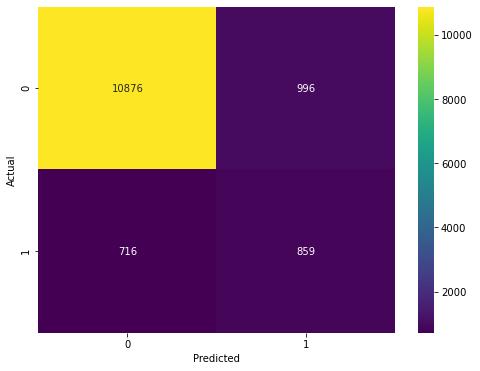

In [49]:
from sklearn.metrics import confusion_matrix
pred_labels = [1 if prob >= optimal_threshold else 0 for prob in pred_proba]

print(classification_report(y_test, pred_labels))

conf_mat = confusion_matrix(y_test, pred_labels)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### We see a drastic improvement in the recall and f1_score for threshold of 0.55 although we sacrificed some accuracy.

## Conclusion

Our main objective is to increase the success ratio with minimal budget. This means we need a good balance of both **Precision** as well as **Recall** for **Class 1**.  
Hence we first obtained the best model based on **roc_auc_score** instead of accuracy_score because our data has class imbalances  
And then we focussed on increasing the **f1_score** for that particular model by **tuning threshold**.  

With the results above we can say the following about our model:  
While keeping the budget optimal,   
**1. Out of the customers we target for the marketing campaign, 46% will take the term deposit (Precision).**  
**2. Out of the prospective term deposit taking customers, we successfully identify 55% of them (Recall).**